In [1]:
from sklearn import cross_validation, linear_model, metrics, preprocessing, ensemble, learning_curve

import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
raw_data = pd.read_csv('sample.csv', header = 0, sep = ';')

In [4]:
raw_data.head()

,ID_CLIENT,FLAG_IPOTEKA,INCOME,GENDER,CHILD_COUNT,HAS_FLAT,AGE,FLAG_FOREIGN_PASSPORT,EDUCATION,TRANSPORT_AMOUNT,target_bin,Target_amt
0,ID_1082,0,41672.965684,0,1,1,35.0,0,3,0,0,0
1,ID_1083,0,229000.507661,1,0,1,37.0,1,3,2,0,0
2,ID_1084,0,68015.394422,0,1,1,29.0,1,3,1,0,0
3,ID_1085,0,67267.075917,1,1,1,55.0,0,4,2,0,0
4,ID_1086,0,71000.578632,0,1,0,72.0,1,3,1,0,0


In [5]:
raw_data.isnull().values.any()

True

In [6]:
X = raw_data.drop('target_bin',1).drop('Target_amt',1)
y1 = raw_data.target_bin

In [7]:
X = X.fillna(0)

Задание 1.
Разделим нашу выборку на обучающую и тестовую. Перемешаем выборку и стратифицируем(сохраним отношение классов в целевой переменной). Тестовую выборку используем для проверки качества

In [8]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X, y1,  
                                                                                     test_size = 0.3,stratify = y1)

Отмасштабируем наши данные, нормализовав их

In [9]:
#масштабируем
from sklearn.preprocessing import StandardScaler

encoder = StandardScaler()
train_data_scaled = encoder.fit_transform(train_data.drop('ID_CLIENT',1))
test_data_scaled = encoder.transform(test_data.drop('ID_CLIENT',1))

In [13]:
ridge_classifier = linear_model.RidgeClassifier(random_state = 1)
ridge_classifier.fit(train_data_scaled, train_labels)
ridge_predictions = ridge_classifier.predict(test_data_scaled)

In [16]:
print metrics.f1_score(test_labels, ridge_predictions)

0.663703703704


In [19]:
print metrics.accuracy_score(test_labels, ridge_predictions)

0.650231124807


In [17]:
log_regressor = linear_model.LogisticRegression(random_state = 1)
log_regressor.fit(train_data_scaled, train_labels)
lr_predictions = log_regressor.predict(test_data_scaled)

In [18]:
print metrics.f1_score(test_labels, lr_predictions)

0.660740740741


In [20]:
print metrics.accuracy_score(test_labels, lr_predictions)

0.647149460709


Rigde классификатор работает лучше в данном случае. Проверим не переобучили ли мы модель

In [24]:
print ridge_classifier.coef_
rg = ridge_classifier.predict(train_data_scaled)
print metrics.accuracy_score(train_labels, rg)

[[ 0.01239593 -0.02616777  0.12330718 -0.09406971 -0.10328783  0.00541051
  -0.11322513  0.13380398 -0.09548359]]
0.63143989432


Модель не переобучена, так как веса по модулю не большие и качество на тренировочной выборке близок к качеству на тестовой

Задание 2.
Построим модель для интервальной целевой переменной

Целевая переменная у нас интервальная, разобьем ее на несколько классов 

In [25]:
y2 = raw_data.Target_amt.values

In [27]:
for i in range(len(y2)):
    if(i>=1000):
        y2[i] = y2[i]/1000

In [28]:
y2

array([0, 0, 0, ..., 5, 1, 5], dtype=int64)

In [29]:
train_data2, test_data2, train_labels2, test_labels2 = cross_validation.train_test_split(X, y2, 
                                                                                         test_size = 0.3, stratify = y2)

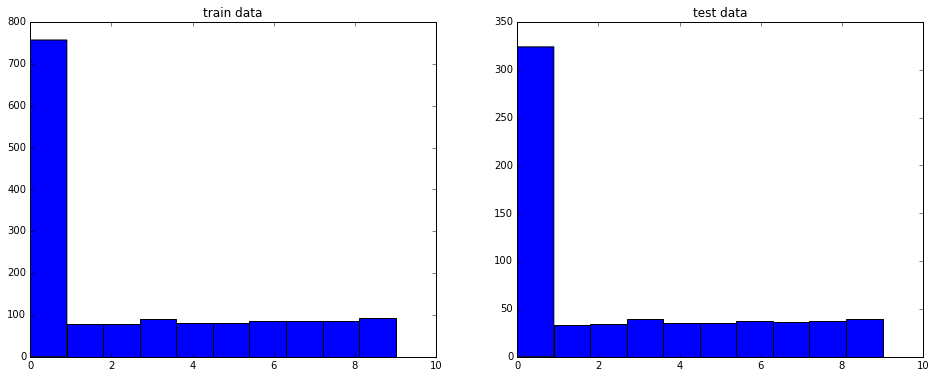

In [30]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels2)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels2)
pylab.title('test data')

In [31]:
#масштабируем
encoder2 = StandardScaler()
train_data_scaled2 = encoder2.fit_transform(train_data2.drop('ID_CLIENT',1))
test_data_scaled2 = encoder2.transform(test_data2.drop('ID_CLIENT',1))

Классов у нас получилось 10, воспользуемся для начала случайным лесом, потому что он обычно не переобучается.
Так как на графике видно, что выборка у нас не сбалансирована то добавим балансировку в метод.  

In [40]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 50, max_depth = 20, random_state = 1, class_weight = 'balanced')

In [41]:
train_sizes, train_scores, test_scores=learning_curve.learning_curve(rf_classifier, train_data_scaled2, train_labels2, 
                                                                     train_sizes=np.arange(0.1,1., 0.2), cv=10, scoring='mean_absolute_error')

In [42]:
print train_sizes
print train_scores.mean(axis = 1)
print test_scores.mean(axis = 1)

[ 135  407  679  950 1222]
[ 0.          0.         -0.00073638  0.         -0.00278232]
[-2.66664878 -2.60785484 -2.6139851  -2.59582806 -2.63738143]


In [43]:
rf_classifier.fit(train_data_scaled2,train_labels2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [44]:
rf_predictions2 = rf_classifier.predict(test_data_scaled2)

In [91]:
print metrics.confusion_matrix(test_labels2, rf_predictions2)

[[271   8   3   6   6   6   4   6   6   8]
 [ 25   0   1   2   0   1   0   0   3   1]
 [ 21   1   0   1   2   1   0   1   1   6]
 [ 26   2   0   3   1   1   1   1   2   2]
 [ 20   3   0   1   2   1   1   5   1   1]
 [ 21   2   1   0   2   2   0   2   2   3]
 [ 25   1   1   0   2   1   0   1   2   4]
 [ 21   2   1   5   2   0   1   1   0   3]
 [ 21   1   0   0   2   2   2   5   2   2]
 [ 26   1   4   0   1   3   2   1   1   0]]


In [55]:
rf_predictions2[:100]

array([0, 0, 0, 6, 0, 0, 4, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 2, 9, 0, 0, 0,
       0, 7, 0, 0, 9, 9, 5, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 1, 5, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 3, 6, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
       0, 0, 7, 8, 0, 0, 0, 4], dtype=int64)

In [56]:
test_labels2[:100]

array([3, 0, 1, 8, 0, 0, 7, 0, 7, 5, 0, 1, 7, 0, 5, 0, 0, 9, 7, 0, 7, 0, 0,
       0, 0, 5, 0, 2, 2, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 4, 0, 4, 7,
       5, 0, 0, 9, 3, 3, 3, 8, 8, 0, 1, 0, 0, 6, 4, 8, 0, 9, 0, 6, 0, 0, 8,
       0, 9, 7, 0, 0, 6, 8, 2, 0, 0, 4, 9, 0, 0, 4, 0, 0, 3, 0, 0, 0, 5, 0,
       1, 0, 4, 6, 5, 0, 2, 6], dtype=int64)

In [74]:
from sklearn.ensemble import GradientBoostingRegressor as XGB

In [93]:
clss = XGB(alpha=0.1)
clss.fit(train_data_scaled2,train_labels2)

GradientBoostingRegressor(alpha=0.1, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [94]:
print metrics.mean_absolute_error(test_labels2, clss.predict(test_data_scaled2))

2.61413878905


In [92]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_data_scaled2, train_labels2)

metrics.confusion_matrix(test_labels2, model.predict(test_data_scaled2))

array([[258,  16,   1,   3,  37,   0,   1,   0,   8,   0],
       [ 22,   2,   0,   0,   9,   0,   0,   0,   0,   0],
       [ 19,   2,   0,   0,   9,   0,   0,   0,   3,   1],
       [ 20,   3,   0,   1,  13,   0,   0,   0,   2,   0],
       [ 24,   0,   0,   0,   9,   0,   1,   0,   1,   0],
       [ 19,   4,   0,   0,   9,   0,   0,   0,   3,   0],
       [ 25,   1,   0,   0,   8,   0,   0,   0,   1,   2],
       [ 23,   1,   1,   0,   8,   0,   0,   0,   3,   0],
       [ 25,   2,   0,   0,   8,   0,   1,   0,   0,   1],
       [ 23,   4,   1,   1,   6,   0,   1,   0,   2,   1]])

In [95]:
print metrics.mean_absolute_error(test_labels2, model.predict(test_data_scaled2))

2.48228043143


In [96]:
metrics.confusion_matrix(train_labels2, model.predict(train_data_scaled2))

array([[629,  27,   1,   6,  72,   0,   4,   0,  15,   3],
       [ 48,   5,   0,   0,  16,   0,   0,   0,   9,   0],
       [ 47,   3,   0,   0,  23,   0,   0,   0,   4,   1],
       [ 56,   7,   0,   0,  23,   0,   0,   0,   4,   1],
       [ 42,   6,   0,   1,  27,   0,   0,   0,   5,   0],
       [ 52,   5,   0,   0,  20,   0,   0,   0,   2,   1],
       [ 59,   6,   1,   1,  13,   0,   1,   0,   4,   1],
       [ 53,   4,   0,   0,  26,   0,   0,   0,   2,   0],
       [ 54,   4,   0,   2,  18,   0,   0,   0,   6,   2],
       [ 54,   3,   0,   1,  29,   0,   1,   0,   3,   1]])

Байесовский классификатор работает немного стабильней и точнее остальных и явно не переобучен это видно по матрице ошибок